# RANSAC



## Import Modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## RANSAC Localization with Tsai's Method

We apply RANSAC to localization for the KITTI dataset.

### Load Data
The following data are given:

1.  Database image `data/000000.png`
2.  Keypoints in the **database** image `data/keypoints.txt`
3.  3D location of the keypoints in the W-frame `data/p_W_landmarks.txt`

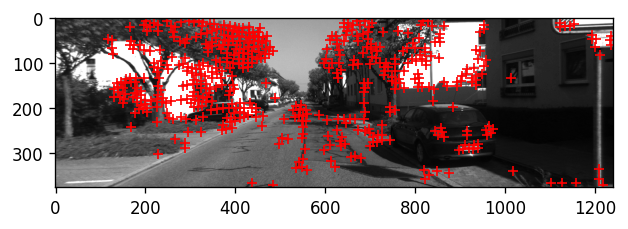

In [2]:
img_database = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
keypoints_database = list(map(tuple, np.loadtxt('data/keypoints.txt', dtype='int')-1)) # list of (row, col)
K = np.loadtxt('data/K.txt')
p_W_landmarks = np.loadtxt('data/p_W_landmarks.txt').T

plt.figure(dpi=120)
plt.imshow(img_database,cmap='gray')
plt.plot(np.array(keypoints_database).T[1,:],np.array(keypoints_database).T[0,:],'r+')

### Generate Keypoints and World Coordinates

Suppose a query image is given by `data/000001.png`. We wish to find the relative pose of the **query** image.

Since the 3D world coordinates of the keypoints are already given above, we can utilize Tsai's method. (See the course note "Camera Calibration", HW#5, `python_example/Harris_feature`)

For Tsai's method, we need key points in the query image, and the corresponding 3D location, which can be discovered by matching the features of the query image to the database image. In other words, 

(keypoints in the query image `000001`) ==(Harris detector/matching)==> (keypoints in the database image `000000`) ==(given data)==> (3D world coordinates)

We need RANSAC as the matched features may contain outliers.


For the keypoint matching, we will utilize the Harris detector that we developed in HW#5. Recall the following functions:

```
mae6292.harris_corner(img, W, kappa):
    # Compute harris corner score
    # INPUT
    #   img: gray scale image
    #   W: harris patch size (patch width= 2*W+1)
    #   kappa: kappa in the harris score
    # OUTPUT
    #   harris_score: array of the same size as the input image

mae6292.select_keypoints(score, N_keypoint, W_nms):
    # Select keypoints from Harris score
    # INPUT
    #   score: array of Harris score
    #   N_keypoints: number of keypoints to be detected
    #   W_nms: patch size for non maximum supression
    # OUTPUT
    #   keypoints: list of tuples (row,col) for the keypoints

mae6292.describe_keypoints(img, keypoints, W):
    # Extract descriptors as patches centered at keypoints 
    # INPUT
    #   img: image
    #   keypoints: list of tuples (row,col) for keypoints
    #   W: descriptor patch size
    # OUTPUT
    # descriptor: array of len(keypoints) by (2*W+1)**2 

mae6292.match_descriptors(descriptors_new, descriptors_old, lambda_match):
    # Match descriptors
    # INPUT
    # descriptors_new (query): array of N_descriptor_new by (2*W+1)**2 
    # descriptors_old (database): array of N_descriptor_old by (2*W+1)**2 
    # lambda_match: match if distance >= lambda_match * min_nonzero_distance
    # OUTPUT
    # unique_match: 
    # if unique_match >= 0:
    #   descriptors_new[:,i] is closest to descriptors_old[:,match[i]]
    # else
    #   descriptors_new[:,i] is not matched to any
    # distance: distance 

```

In short, 

1.  Find the keypoints in the query image `000001`, and compute descriptors.
2.  Compute descriptors in the database image `000000`. (No need to compute keypoints, as they are already given).
3.  Match descriptors between the query image and teh database image.
4.  Matched keypoints in the query, and the corresponding 3D locations are saved for DLT.

We choose parameters from HW#5 as
```
W_harris_patch = 4
harris_kappa = 0.08
N_nms = 8
W_descripto = 9
match_lambda = 5
N_keypoints = 1000
```



total number of keypoints =  1000
number of matched discriptors =  271


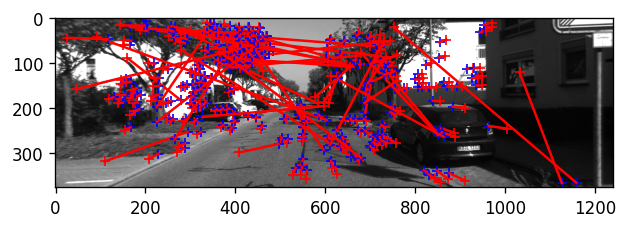

In [3]:
W_harris_patch = 4
harris_kappa = 0.08
W_nms = 8
W_descriptor = 9
lambda_match = 5
N_keypoint = 1000

# 1. imq_query: detect keypoints and compute descriptor
img_query = cv2.imread('data/000001.png',cv2.IMREAD_GRAYSCALE)
harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)

# 2. imq_database: compute descriptor
descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)

# 3. match descriptors 
match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
index_match = np.where(match>=0)[0].tolist()

# 4. extract matched keypoints and 3D world coordinates
keypoints_query_matched = [keypoints_query[i] for i in index_match]
keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
p_W_matched = p_W_landmarks[:, match[index_match]]

# Visualize
plt.figure(dpi=120)
plt.imshow(img_database,cmap='gray')

for i in index_match: # iteration on matched keypoints
    v_q, u_q = keypoints_query[i] # matched keypoints on img1
    v_d, u_d = keypoints_database[match[i]] # matched keypoints on img
    
    plt.plot(u_q, v_q, 'r+') 
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')

print('total number of keypoints = ', len(keypoints_query) )
print('number of matched discriptors = ', len(index_match) )



### RANSAC Localization

Now, in the query image, we have 

1. pixel coordinates of features, `keypoints_query_matched`
2. 3D world coordinates of features, `p_W_matched`

However, as visualized above, there are a lot of incorrect matches, or outliers.


We will perform robust DLT (Tsai's method) while eliminating outliers with RANSAC 

0. Set `N_inliers_max = 0`
1.  Randomly select $s=6$ points using [np.random.choice(..., ..., replace=False)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) It is important that no points are repeated!
2.  Estimate the pose using `mae6292.estimate_pose_DLT(p,P,K)`, which is a special case of Tsai's method when $K$ is known.


```
    R, T, R_T = mae6292.estimate_pose_DLT(p, P, K):
        # DLT using Tsai's method assuming that K is known
        # INPUT
        # p : homogeneous coordinates of pixel in the image frame
        # P : homogeneous coordinates of points in the world frame
        # OUTPUT
        # R, T, [R|T]
```

NOTE: keypoints are saved as the list of `(row, col)`. Therefore, when converting `keypoints` to `p=[u,v,1]`, the order should be flipped!

3.  Using the estimated $(R,T)$, project each of `p_W_matched` into the image plane using the perspective projection `K@[R|T]`, and compute the reprojection error. 
If the reprojection error is less than `tol_inlier=10` pixels, then declare it as inlier.

4.  If `N_inliers > N_inliers_max`, save the current inliers.
5.  Repeat the above 1-4.
6.  Estimate the pose using the inliers only.

Since $s=6$, we need 292 iterations when $w=0.5$ and $p=0.99$. One can estimate the inlier ratio online, and change the number of iterations accordingly for early stopping.



i_iter=4, N_inliers=5, w=0.02
i_iter=24, N_inliers=157, w=0.58
i_iter=57, N_inliers=220, w=0.81
i_iter=127, N_inliers=221, w=0.82
i_iter=202, N_inliers=222, w=0.82
R= [[ 9.99996004e-01  2.04941238e-03  1.94725477e-03]
 [-2.05070548e-03  9.99997678e-01  6.62299230e-04]
 [-1.94589292e-03 -6.66289829e-04  9.99997885e-01]]
T= [[ 0.00569428]
 [ 0.0136472 ]
 [-0.72136923]]


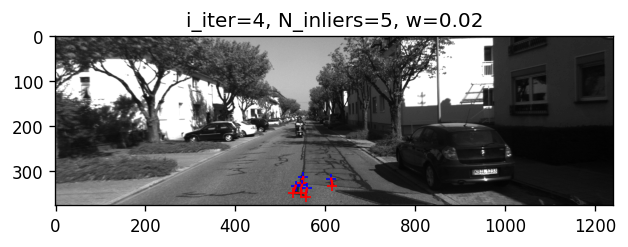

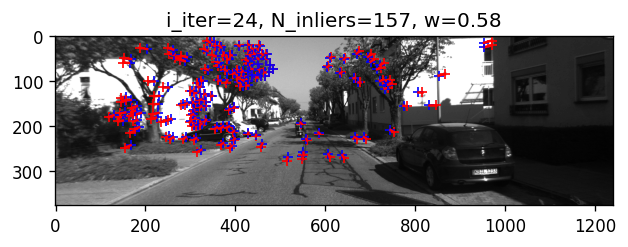

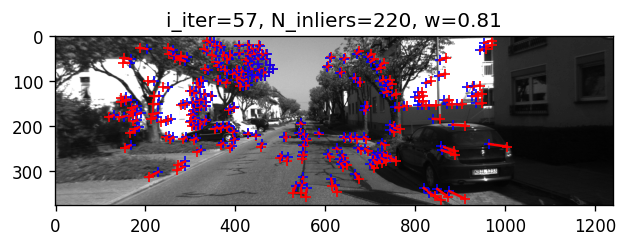

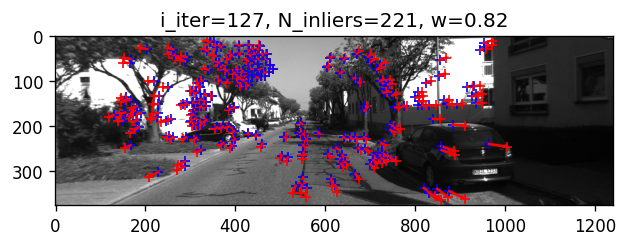

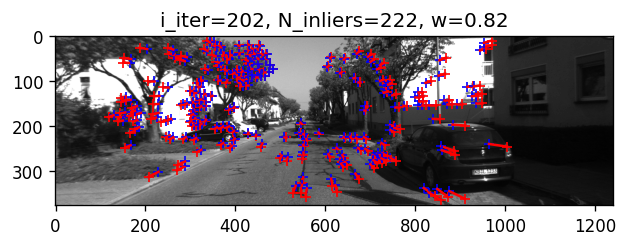

In [4]:
N_inliers_max = 0
N_iter = 1000
tol_inlier = 10
display_iter = True

# convert list of keypoint to array
p_matched = np.array(keypoints_query_matched).T 
# flip (row,col) into image coordinate (u,v)
p_matched = p_matched[[1,0],:] 
# transform to homogeneous coordinates
p_matched = np.concatenate((p_matched, np.ones((1,p_matched.shape[1])) ), axis=0) 

# extract matched 3D points and transform to homogeneous coordinates
p_W_matched = p_W_landmarks[:, match[index_match]]
p_W_matched = np.concatenate((p_W_matched, np.ones((1,p_W_matched.shape[1])) ), axis=0) 

for i_iter in range(N_iter):

    # sample 6 points from the matched keypoints and estimate pose using them
    i_sample = np.random.choice(len(keypoints_query_matched), 6, replace=False)
    R, T, R_T = mae6292.estimate_pose_DLT(p_matched[:, i_sample], p_W_matched[:,i_sample], K)

    # compute the reprojection error
    p_matched_est = K @ R_T @ p_W_matched
    error = np.sqrt(np.sum((p_matched_est[0:2,:]/p_matched_est[2,:]-p_matched[0:2,:]/p_matched[2,:])**2, axis=0))
    
    # identify inliers
    i_inliers = np.where(error < tol_inlier)[0]

    # if the number of inliers is the best, save the list of inliers
    if len(i_inliers) > N_inliers_max:
        i_inliers_best = i_inliers
        N_inliers_max = len(i_inliers)
        output = 'i_iter=%d, N_inliers=%d, w=%.2f' % (i_iter,N_inliers_max,N_inliers_max/p_matched.shape[1])
        print(output)
        if display_iter and i_iter !=1:
            # visualize inliers
            plt.figure(dpi=120)
            plt.imshow(img_query,cmap='gray')
            plt.title(output)
            for i in i_inliers:
                v_q, u_q = keypoints_query_matched[i] # matched keypoints on img1
                v_d, u_d = keypoints_database_matched[i] # matched keypoints on img

                plt.plot(u_q, v_q, 'r+') 
                plt.plot(u_d, v_d, 'b+')
                plt.plot([u_d,u_q],[v_d,v_q],'r')

# estimate the pose using inliers only
R, T, M = mae6292.estimate_pose_DLT(p_matched[:, i_inliers_best], p_W_matched[:,i_inliers_best], K)
print('R=',R)
print('T=',T)